# Color quantization with Gaussian mixture model and yellow lines labelled with boxes

This notebook is based on notebook 7.1 with combining Li's code on Gaussian mixture model. 

In [1]:
# import libraries
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import cv2
from pathlib import Path
from sklearn.mixture import GaussianMixture as GMM

In [2]:
# define reshaped size
WIDTH = 512
HEIGHT = 512

In [3]:
# define a list with all file names
pl = Path("Parking Lot")
rd = Path("Road")

filenames = [str(file) for file in pl.iterdir()]
filenames = filenames + [str(file) for file in rd.iterdir()]

num_files = len(filenames)

In [4]:
# load images
ims = [cv2.resize(cv2.imread(file),(WIDTH,HEIGHT)) for file in filenames]

In [5]:
# reshape the list
pixel_list = [im.reshape((-1, 3)) for im in ims]
pixels = np.concatenate(pixel_list, axis=0)

In [6]:
#gaussian mixture models
gmm_model = GMM(n_components = 10, covariance_type = 'tied').fit(pixels)

In [7]:
# define the yellow color and predict the label 
yellow = np.array([0, 200, 210 ])
yellow_label = gmm_model.predict(yellow.reshape((1, -1)))

In [8]:
# save all the clustered images and the resulting images after filtering 

for index in range(num_files):
    filename = filenames[index].split('/')[-1].split('.')[0]
    
    resized_img = pixels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization_MG/Resized_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,resized_img)
    
    colors = gmm_model.means_
    img_labels =  gmm_model.predict(pixels)
    transformed_img = colors[(img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)])].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization_MG/Transformed_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,transformed_img)

    mask = (img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)] == yellow_label).reshape((HEIGHT, WIDTH, 1))
    masked_image = ims[index]*mask
    output_name = "Output/Color_Quantization_MG/Masked_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,masked_image)

Our resized image has the shape: (512, 512, 3)


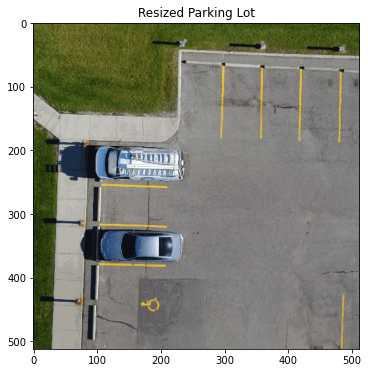

In [9]:
# load resized image
filen = "Lot1"
resizedfilename = "Output/Color_Quantization_MG/Resized_"+filen+".jpg"
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Resized Parking Lot');
print("Our resized image has the shape: {}".format(img_resized.shape))
plt.imshow(img_resized)
plt.show()

Our masked image has the shape: (512, 512, 3)


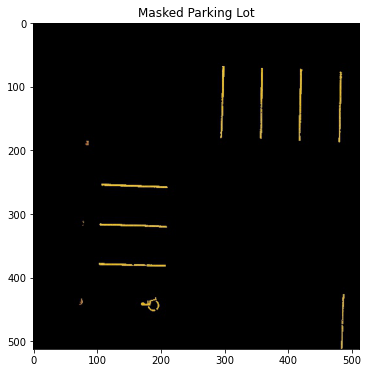

In [10]:
# load masked image
maskedfilename = "Output/Color_Quantization_MG/Masked_"+filen+".jpg"
masked_img = cv2.imread(maskedfilename, 1)
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Masked Parking Lot');
print("Our masked image has the shape: {}".format(masked_img.shape))
plt.imshow(masked_img)
plt.show()

In [11]:
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

In [12]:
# parameters kernel size and sigma in Gaussian blurring
gblur = cv2.GaussianBlur(masked_img, (7,7),0)

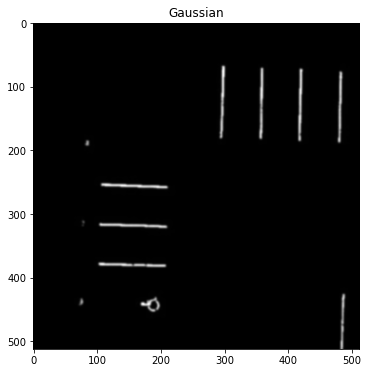

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(gblur, cmap = 'gray')
plt.title('Gaussian');
plt.show()

In [14]:
# two parameters need to play with in canny edge detection
minval = 150
maxval = 280
canny_bF = cv2.Canny(gblur, minval, maxval)

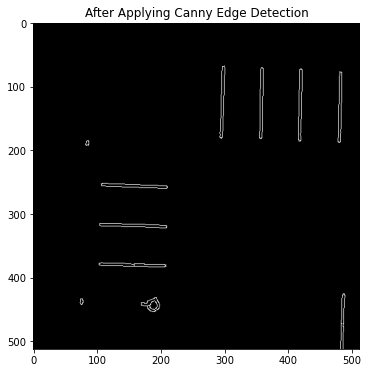

True

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(canny_bF, cmap = 'gray')
plt.title('After Applying Canny Edge Detection');
plt.show()
finaloutname = "Output/Color_Quantization_MG/Edge_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname,canny_bF )

In [16]:
# three parameters need to play with
lines = cv2.HoughLinesP(canny_bF, 1, np.pi/180, threshold = 19, minLineLength = 10, maxLineGap = 10)

In [17]:
# draw lines
for line in lines:
    x1, y1, x2, y2 = line[0]   
    im = cv2.line(img_resized, (x1,y1), (x2, y2), ( 255, 0, 0), 2)

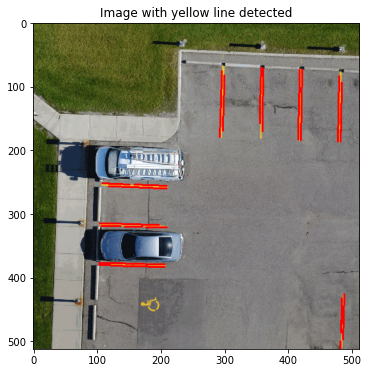

True

In [18]:
#img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(im)
plt.title('Image with yellow line detected');
plt.show()

# save the image with line detected and display it
finaloutname = "Output/Color_Quantization_MG/Detected_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im)

In [19]:
# load resized images 
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

In [20]:
# get contours based on edge detection results
_, contours,_ = cv2.findContours(canny_bF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [21]:
boxes = []
bbdata = []
# saves contour stat and draw contours over objects
for i in range(len(contours)):
    rect = cv2.minAreaRect(contours[i])
    boxes.append(np.int0(cv2.boxPoints(rect)))
    _ ,_ ,w, h = cv2.boundingRect(contours[i])
    aspect_ratio = max(float(w)/h, float(h)/w)
    area = cv2.contourArea(contours[i])
    bbdata.append([aspect_ratio])
    im1 = cv2.drawContours(img_resized, boxes, -1, (255, 0, 0), 2)

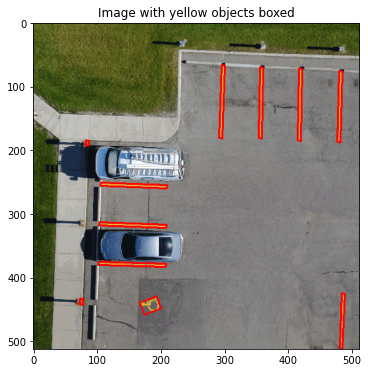

True

In [22]:
# display the object with boxes around
plt.figure(figsize=(6,6))
plt.imshow(im1)
plt.title('Image with yellow objects boxed');
plt.show()

finaloutname = "Output/Color_Quantization_MG/Boxed_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im1)

In [23]:
# do a secondary object clustering if needed by checking the aspect ratio
X = np.array(bbdata)
K = 2
model = KMeans(n_clusters = K)
model.fit(X)

KMeans(n_clusters=2)

In [24]:
properties_of_line = np.array([10]).reshape(1, -1)
label = model.predict(properties_of_line)

In [25]:
# filter out the not needed boxes 
boxes = [boxes[i] for i in np.where(model.labels_ == label)[0]]

In [26]:
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

In [27]:
# draw the countor boxes 
im2 = cv2.drawContours(img_resized, boxes, -1,(255, 0, 0), 2);

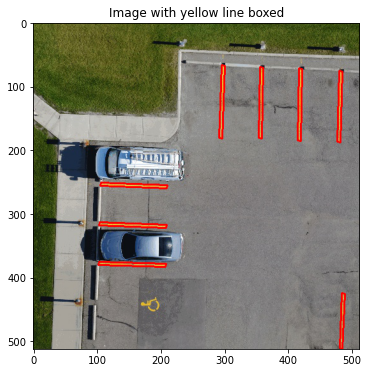

True

In [28]:
# display the results
plt.figure(figsize=(6,6))
plt.imshow(im2)
plt.title('Image with yellow line boxed');
plt.show()

finaloutname = "Output/Color_Quantization_MG/Boxed_line_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im2)